Step 1: Import Libraries

In [15]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from mtcnn import MTCNN
import torch
import pymesh
from matplotlib.patches import Rectangle
from PIL import Image
from transformers import DPTImageProcessor, DPTForDepthEstimation
import open3d as o3d
import pyvista as pv
from trame.widgets import vtk as vtk_widgets
from PIL import ImageEnhance


In [16]:
image_path = "images/img4.jpg"

Step 2: Face Alignment and Cropping

In [17]:
import cv2
import numpy as np

def align_and_crop_face(image):
    detector = MTCNN()
    
    faces = detector.detect_faces(image)
    
    if len(faces) == 0:
        return None, None
    
    face = faces[0]
    x, y, w, h = face['box']
    
    aligned_face = image[y:y+h, x:x+w]
    
    padding = 20  
    cropped_face = aligned_face[padding:-padding, padding:-padding] 
    
    # Create a mask of the same size as the face, filled with 0s
    mask = np.zeros(cropped_face.shape[:2], np.uint8)

    # Define background and foreground model
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)

    # Define the region of interest for GrabCut
    rect = (50,50,w-100,h-100)

    # Run GrabCut
    cv2.grabCut(cropped_face, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

    # Create a binary mask where foreground pixels are set to 1 and background pixels are set to 0
    bin_mask = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')

    # Multiply the original image with the binary mask to get the foreground
    img = cropped_face*bin_mask[:,:,np.newaxis]

    return aligned_face, img


Step 3: Align and Crop

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


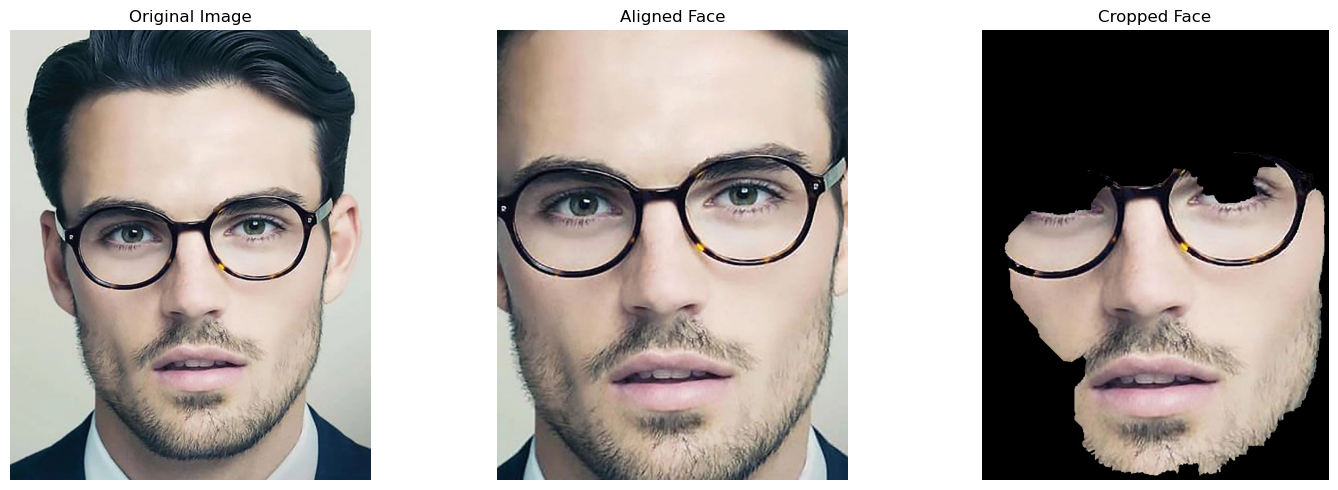

Aligned face saved at: images/aligned_face/aligned_face.jpg
Cropped face saved at: images/cropped_face/cropped_face.jpg


In [18]:
image = plt.imread(image_path)

aligned_face, cropped_face = align_and_crop_face(image)

if aligned_face is not None:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    axes[1].imshow(aligned_face)
    axes[1].set_title("Aligned Face")
    axes[1].axis('off')
    
    axes[2].imshow(cropped_face)
    axes[2].set_title("Cropped Face")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    aligned_face_dir = "images/aligned_face"
    cropped_face_dir = "images/cropped_face"
    os.makedirs(aligned_face_dir, exist_ok=True)
    os.makedirs(cropped_face_dir, exist_ok=True)
    
    aligned_face_path = os.path.join(aligned_face_dir, "aligned_face.jpg")
    cropped_face_path = os.path.join(cropped_face_dir, "cropped_face.jpg")
    
    plt.imsave(aligned_face_path, aligned_face)
    plt.imsave(cropped_face_path, cropped_face)
    
    print("Aligned face saved at:", aligned_face_path)
    print("Cropped face saved at:", cropped_face_path)
    
else:
    print("No face detected in the image.")


Step 4: Estimate Depth

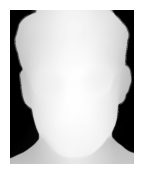

In [20]:
image = Image.open(image_path)
enhancer = ImageEnhance.Contrast(image)
image = enhancer.enhance(2)  # Increase contrast

# Convert image to grayscale
image_gray = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)

# Apply histogram equalization to grayscale image
image_eq = cv2.equalizeHist(image_gray)

# Convert equalized grayscale image back to color
image_np = cv2.cvtColor(image_eq, cv2.COLOR_GRAY2BGR)

# Convert back to PIL Image and process
image = Image.fromarray(image_np)


image = Image.fromarray(image_np)
inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

output = prediction.squeeze().cpu().numpy()

output = cv2.bilateralFilter(output, 9, 75, 75)

formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

plt.figure(figsize=(2,2))
plt.imshow(depth, cmap='gray')
plt.axis('off')
plt.show()


Step 5: 3D Reconstruction

In [21]:
depth = np.array(depth)
rgb = np.array(image_np)

# Create point cloud from depth map
fx, fy = 625.0, 625.0  # Focal lengths
cx, cy = 319.5, 239.5  # Optical center
depth_scale = 1500.0  # Depth scale
width, height = depth.shape[1], depth.shape[0]

intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)

rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    o3d.geometry.Image(rgb),
    o3d.geometry.Image(depth),
    depth_scale=depth_scale,
    depth_trunc=1000.0,
    convert_rgb_to_intensity=False
)

Step 6: Create and save point cloud 

In [22]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    intrinsic
)

o3d.io.write_point_cloud("3d_head.ply", pcd)

True

Step 7: Plot

In [23]:
mesh = pv.read("3d_head.ply")
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(mesh)
plotter.show_grid(color='black')
plotter.show()

Widget(value='<iframe src="http://localhost:62190/index.html?ui=P_0x2f09c1040_0&reconnect=auto" class="pyvista…

Step 8: View in Open3d

In [24]:
pcd = o3d.io.read_point_cloud("3d_head.ply")
o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
